In [1]:
!nvidia-smi

Mon Sep  4 23:47:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Setup

In [2]:
!pip install -q -U sentence-transformers
!pip install -q -U 'google-cloud-bigquery[bqstorage,pandas]'
!pip install cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com

### Librerias

In [2]:
import os
import torch

import matplotlib.pyplot as plt

# from cuml import DBSCAN, TSNE

from google.cloud.bigquery import Client
from google.oauth2.service_account import Credentials

from sentence_transformers import SentenceTransformer

plt.style.use("ggplot")

### Variables

In [4]:
# BigQuery Variables
SERVICE_ACC_FILE="/content/valid-dragon-397303-a396a9a99124.json"
PROJECT_ID="valid-dragon-397303"

# Seed
SEED=1399

In [5]:
try:
    client = Client()
    client.query("SELECT 1 AS NUM")
except Exception as e:
    print(e)
    CREDENTIALS = Credentials.from_service_account_file(SERVICE_ACC_FILE)
    client = Client(project=PROJECT_ID, credentials=CREDENTIALS)

### Dataset

#### Carga de datos

Como el dataset original tiene mas de 130 millones de reviews, para esta primera entrega se utilizaran unicamente los datos relacionados a la categoria de videojuegos.

In [6]:
%%time
# Se traen los datos desde BigQuery
QUERY = (
    "SELECT * "
    "FROM `valid-dragon-397303.amazon_reviews.modeling_data` "
    "WHERE first_category_item = 'Video Games';"
)
job = client.query(QUERY)
data = job.to_dataframe()

CPU times: user 3.29 s, sys: 1.52 s, total: 4.81 s
Wall time: 7.2 s


#### Inspeccionar el dataset

In [7]:
# Se inspeccionan las primeras filas del dataset
data.head()

,review,brand,first_category_item
0,This Exactly what I wanted and I get two of th...,HDE,Video Games
1,Here's my experience with this hard drive:\n\n...,OEM,Video Games
2,I am personally not a fan of RPGs like Final F...,THQ,Video Games
3,halo is the game that sets the bar for all fir...,Nyko,Video Games
4,Railroad Tycoon could be every boys dream. Ima...,Sega,Video Games


In [8]:
# Se verifica la estructura de los datos
print(f"Filas: [{data.shape[0]}], Columnas [{data.shape[1]}]")

Filas: [1722888], Columnas [3]


In [9]:
# Se verifican los tipos de datos
data.dtypes.to_frame().T

,review,brand,first_category_item
0,object,object,object


- El conjunto de datos tiene 1.722.888 filas, de las cuales, cada una corresponde a un review diferente a un objeto dentro de la categoria de video juegos de Amazon.
- El conjunto de datos tiene 3 columnas: `review` que corresponde al review del objeto, `brand` que corresponde a la marca del objeto y `first_category_item` que corresponde a la categoria del objeto.

#### Descripción de los datos

In [11]:
data.describe()

,review,brand,first_category_item
count,1722888,1722888,1722888
unique,1281247,5839,1
top,good,by\n \n Nintendo,Video Games
freq,3663,142373,1722888


- Hay 1,281,247 reseñas distintas, siendo "good" la más repetida con 3,663 ocasiones.
- Existen 5,839 marcas diferentes de videojuegos. Además, se removerá el string "by \n \n " para hacer la marca más comprensible.
- Solo hay una categoría, ya que únicamente estamos trabajando con videojuegos.

In [12]:
data["brand"] = data["brand"]\
    .str.replace("by", "", regex=False)\
    .str.replace("\n", "", regex=False)\
    .str.strip()

<Axes: title={'center': 'Distribucion de reviews por marca\ntop 20'}, xlabel='%', ylabel='Marca'>

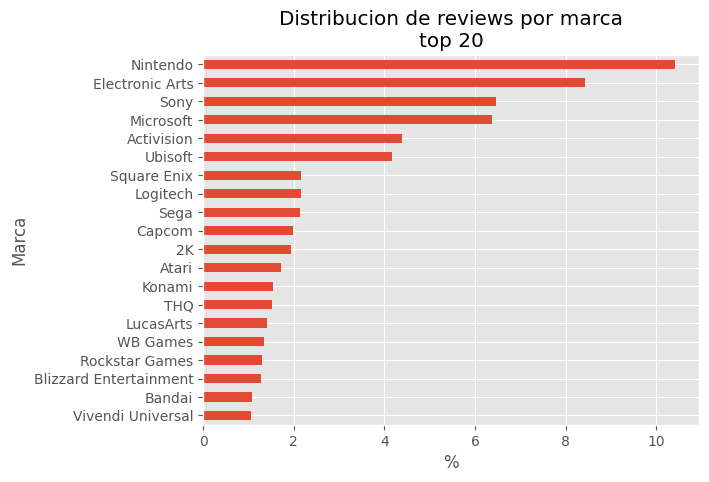

In [13]:
(data["brand"].value_counts(True).nlargest(20) * 100).sort_values()\
    .plot(kind="barh", title="Distribucion de reviews por marca\ntop 20", xlabel="%", ylabel="Marca")

- Entre Nintendo, EA, Sony, Microsoft y Activision se encuentra el 30% de los datos.
- Las demás marcas representan entre un 1% y 2% de los datos.

<Axes: title={'center': 'Distribucion de longitud de reviews'}, xlabel='Longitud de la review', ylabel='Numero de Reviews'>

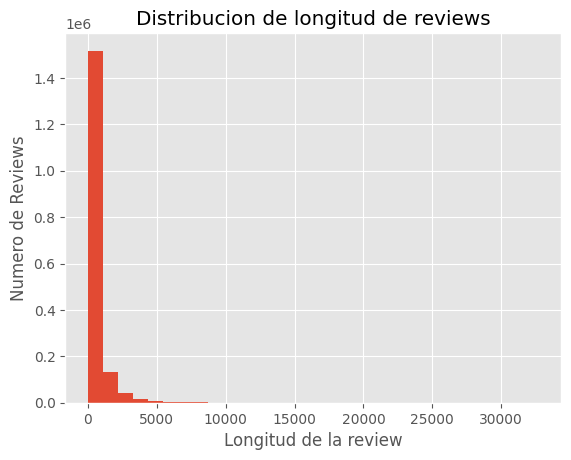

In [14]:
data["review"].str.len()\
    .plot(kind="hist", bins=30, title="Distribucion de longitud de reviews", xlabel="Longitud de la review", ylabel="Numero de Reviews")

In [15]:
data["review"].str.len().describe().to_frame().round(2)

,review
count,1722888.00
mean,511.02
std,919.50
min,1.00
25%,96.00
50%,205.00
75%,547.00
max,32721.00


- En promedio, las reseñas tienen 500 caracteres. Además, el 75% de los datos cuenta con aproximadamente 550 caracteres o menos.
- Hay reseñas con una longitud fuera de lo común; la más larga alcanza los 32,721 caracteres.

### Modelado

#### Embeddings de las reviews

Para usar las reseñas como entrada en algoritmos no supervisados, necesitamos convertir esos textos en una forma numérica, conocida como "embeddings". Para hacer esto, vamos a usar el modelo `all-distilroberta-v1`. Este modelo es una versión "destilada" (más ligera y rápida, pero casi igual de precisa) de RoBERTa, y ha sido adaptado específicamente para este tipo de tareas. El modelo convierte los párrafos en vectores en un espacio de 768 dimensiones. Además, es importante saber que la longitud máxima que el modelo puede manejar es de 512 caracteres. Esto encaja bastante bien con las características de nuestro conjunto de datos. Si alguna reseña tiene más de 512 caracteres, se cortará para ajustarse a este límite.Para usar las reseñas como entrada en algoritmos no supervisados, necesitamos convertir esos textos en una forma numérica, conocida como "embeddings". Para hacer esto, vamos a usar el modelo all-distilroberta-v1. Este modelo es una versión "destilada" (más ligera y rápida, pero casi igual de precisa) de RoBERTa, y ha sido adaptado específicamente para este tipo de tareas. El modelo convierte los párrafos en vectores en un espacio de 768 dimensiones. Además, es importante saber que la longitud máxima que el modelo puede manejar es de 512 caracteres. Esto encaja bastante bien con las características de nuestro conjunto de datos. Si alguna reseña tiene más de 512 tokens, se cortará para ajustarse a este límite.

In [16]:
# Se carga el modelo
MODEL_NAME = "sentence-transformers/all-distilroberta-v1"
model = SentenceTransformer(MODEL_NAME, device="cuda")

In [17]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [13]:
%%time
embeddings = model.encode(
    sentences=data["review"].to_numpy(),
    batch_size=128,
    device="cuda",
    convert_to_numpy=True,
    show_progress_bar=True
)

100%|██████████| 432/432 [44:52<00:00,  6.23s/it]

CPU times: user 1h 5min 59s, sys: 44.7 s, total: 1h 6min 44s
Wall time: 44min 52s


In [16]:
embeddings.shape

torch.Size([1722888, 768])

In [17]:
type(embeddings[0])

torch.Tensor

### Reduccion de dimensionalidad

Una vez obtenidos los embeddings, estos se pueden utilizar en algoritmos no supervisados. Sin embargo, dado que tienen 768 dimensiones, encontrar clusters de reseñas se vuelve complicado. Por esta razón, aplicaremos una técnica de reducción de dimensionalidad.

In [25]:
model = TSNE(n_components=2, random_state=SEED, method="fft", perplexity=50, n_neighbors=50*3)
truncated_embeddings = model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [18:46:05.193026] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


#### Visualizamos los embeddings

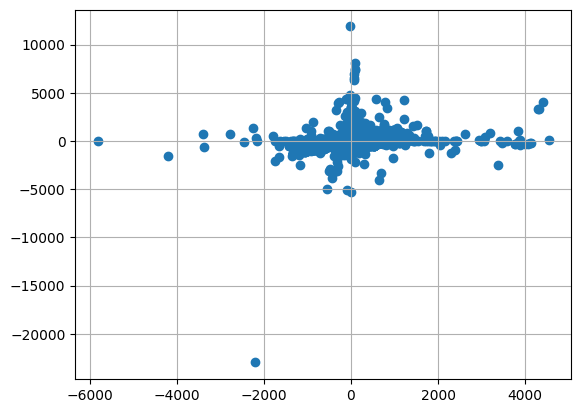

In [26]:
plt.scatter(x=truncated_embeddings[:, 0].get(), y=truncated_embeddings[:, 1].get())
plt.grid()

### Clusters

In [32]:
cluster = DBSCAN()
cluster.fit(truncated_embeddings)

[W] [19:13:42.901764] Batch size limited by the chosen integer type (4 bytes). 3942 -> 1246. Using the larger integer type might result in better performance


DBSCAN()

In [33]:
cluster_labels = cluster.predict(truncated_embeddings)

AttributeError: ignored